In [51]:
# Final_Samples
import pandas as pd
import numpy as np
import json
import random
usable_samples_ADNI = json.load(open('./usable_samples_ADNI.json'))
PRS_orig_feature_matrix = np.load('./PRS_feature_matrix.npy').astype(np.float32)
PRS_orig_feature_matrix = (PRS_orig_feature_matrix - PRS_orig_feature_matrix.mean(0))/PRS_orig_feature_matrix.std(0)
PRS_orig_feature_matrix.shape[1], len(usable_samples_ADNI), usable_samples_ADNI
num_features=PRS_orig_feature_matrix.shape[1]
print(num_features)

26


In [52]:
num_features = 25

In [77]:
try: 
    os.mkdir("shap/" + str(num_features)) 
except OSError as error: 
    print("Folder already exists!")  

In [53]:
PRS_feature_matrix = PRS_orig_feature_matrix
PRS_feature_matrix = PRS_feature_matrix[:, :num_features]
print(PRS_feature_matrix.shape)

(1816, 25)


In [54]:
a = np.array([['a',1],['b',2],['c',3],['d',4]]).tolist()
random.shuffle(a)
a

[['b', '2'], ['a', '1'], ['d', '4'], ['c', '3']]

In [55]:
df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
print("shape",df.shape)
print( df[['AGE', 'PTGENDER']].shape, df[['AGE', 'PTGENDER']].dropna().shape )
print( df.head() ) # PC - Principal Component

shape (1817, 14)
(1817, 2) (1817, 2)
                FID               IID       PC1       PC2       PC3       PC4  \
0  ADNI3_036_S_6231  ADNI3_036_S_6231 -0.006724 -0.010617  0.001596 -0.000460   
1  ADNI3_006_S_6277  ADNI3_006_S_6277 -0.010432 -0.010269  0.012757  0.006921   
2  ADNI3_129_S_6146  ADNI3_129_S_6146 -0.004919 -0.011656 -0.035521  0.064641   
3  ADNI3_033_S_6352  ADNI3_033_S_6352 -0.014069 -0.010279  0.020014  0.053023   
4  ADNI3_027_S_6183  ADNI3_027_S_6183 -0.010766 -0.012370 -0.010960  0.029830   

        PC5       PC6       PC7       PC8       PC9      PC10  PTGENDER   AGE  
0 -0.013131 -0.005855 -0.005142 -0.009063 -0.001739 -0.012863         1  69.1  
1 -0.014958 -0.005860 -0.027775 -0.009632  0.054966  0.087390         1  70.7  
2  0.012094  0.003860  0.035955  0.006561  0.019736 -0.023304         1  65.5  
3  0.023691  0.000247 -0.002273 -0.030627 -0.053461  0.049984         0  71.4  
4 -0.019520 -0.001955  0.023844  0.079138  0.002207  0.008892         0  65.

In [56]:

# COVAR_FILE = df.to_numpy()[:, 2:].astype(np.float32)
cnt = 0
print("shape1",PRS_feature_matrix.shape)
FEATURE_MATRIX = np.concatenate([PRS_feature_matrix, np.zeros([PRS_feature_matrix.shape[0], 12])], 1).astype(np.float32)
print("shape2",FEATURE_MATRIX.shape)
for sample in usable_samples_ADNI:
    covar = df[df['IID'] == sample].to_numpy()[:, 2:].astype(np.float32) # taking from the PCs, skipping the first two columns of IID, FID
#     if cnt < 2:
#         print(covar)
    if covar.shape[0] != 1:
#         print(sample)
        cnt += 1
        continue
#     FEATURE_MATRIX[usable_samples_ADNI[sample], 23:] = covar
# cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

    FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar # naeem's modification
cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

shape1 (1816, 25)
shape2 (1816, 37)


(0.1288546255506608,
 array([[ 1.5471818e+00,  4.2786098e-01, -2.5817478e-01,  1.3769143e+00,
         -7.1390218e-01,  4.4062281e-01,  2.1130602e-01,  1.1038882e+00,
          1.1477689e+00,  3.6035888e-02, -5.6206602e-01,  6.5592009e-01,
         -8.1201518e-01,  6.0254073e-01,  1.4735116e+00, -5.8913165e-01,
          4.1337675e-01, -1.0208811e+00,  1.1957877e+00,  3.8611200e-01,
          6.7549521e-01,  2.0768111e+00,  4.7303710e-02,  1.5833879e+00,
          3.4892298e-02, -6.7239902e-03, -1.0617300e-02,  1.5955199e-03,
         -4.6042900e-04, -1.3131300e-02, -5.8546802e-03, -5.1415302e-03,
         -9.0632401e-03, -1.7389200e-03, -1.2863100e-02,  1.0000000e+00,
          6.9099998e+01],
        [ 2.8968764e-02, -1.8602200e-01,  1.0644186e+00, -2.8283790e-01,
         -2.8895292e-01,  3.0547190e-01, -2.7886992e-02,  7.2349036e-01,
          4.3087134e-01, -5.2110817e-02, -4.5909986e-01,  2.4560858e-01,
          2.1927162e-01,  3.2023571e-02, -3.7697020e-01,  5.6008160e-01,
    

In [57]:
!conda list

# packages in environment at C:\ProgramData\Anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
alabaster                 0.7.12                   py37_0  
anaconda                  2020.02                  py37_0  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.12                   py37_0  
anaconda-project          0.8.4                      py_0  
appdirs                   1.4.3                    pypi_0    pypi
argh                      0.26.2                   py37_0  
asn1crypto                1.3.0                    py37_0  
astroid                   2.3.3                    py37_0  
astropy                   4.0              py37he774522_0  
atomicwrites              1.3.0                    py37_1  
attrs                     19.3.0                     py_0  
autopep8                  1.4.4                      py_0  
babel                     2.8.

In [58]:
def save_in_file(model_name, accuracy):
    model_file = open("model_details.txt","a")
    model_file.write(model_name + " -> accuracy : " + str(accuracy) + "\n" )
    model_file.close() 

In [59]:
if True:   
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn


import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable

feature_indices_to_consider = list(range(23))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
hidden = 4
class simple_model(nn.Module):
    def __init__(self, num_features=FEATURE_MATRIX.shape[1], hidden_dim=32*4, drop_probab=0.3):
        super(simple_model, self).__init__()
        
        ####
        self.drop_probab = drop_probab
        self.dropout_feature = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.dropout1 = nn.Dropout(p=self.drop_probab)
        num_hidden = hidden
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.dropout_hidden = nn.ModuleList([nn.Dropout(p=0.0) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.dropout2 = nn.Dropout(p=0.3)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.num_hidden = num_hidden
        ####

    def forward(self, features):
        features = self.dropout_feature(features)
        features = self.fc1(features)
        features = self.dropout1(features)
        for i in range(self.num_hidden):
            features = self.fc_hidden[i](features)
            features = self.dropout_hidden[i](features)
        features = self.fc2(features)
        features = self.dropout2(features)
        logit = self.outLayer(features)
#         print(features.shape, features)
        probab = self.sigmoid(logit)
        return probab
    

In [60]:
if True:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn


import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable

# feature_indices_to_consider = list(range(23))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# naeem modified
feature_indices_to_consider = list(range(num_features))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]

hidden = 6
hidden_dimension = 48
class simple_model(nn.Module):
    def __init__(self, num_features=FEATURE_MATRIX.shape[1], hidden_dim=32, drop_probab=.8):
        super(simple_model, self).__init__()
        
        ####
        num_hidden = hidden
        hidden_dim = hidden_dimension
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.num_hidden = num_hidden
        self.drop_probab = drop_probab
        self.dropout = nn.functional.dropout
        ####

    def forward(self, features):
        features = self.fc1(features)
        features = self.dropout(features, p=self.drop_probab)
        for i in range(self.num_hidden):
            features = self.fc_hidden[i](features)
        features = self.fc2(features)
        features = self.dropout(features, p=self.drop_probab)
        logit = self.outLayer(features)
#         print(features.shape, features)
        probab = self.sigmoid(logit)
        return probab
    

In [61]:
import json
import numpy as np
import random

In [62]:
Final_Samples = json.load(open('Final_Samples.json', 'r')) 
print(len(Final_Samples))
print(Final_Samples[:2])
positive_samples = Final_Samples[:654] # Final_Samples[654:]
positive_samples = Final_Samples[:654]
negative_samples = Final_Samples[654:]
random_seed = None
if random_seed is not None: 
    random.seed(random_seed * 2)
random.shuffle(positive_samples)
random.shuffle(negative_samples)
Final_Samples = positive_samples[:500] + negative_samples[:500]
print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
Final_Samples = np.array(Final_Samples)
Final_Samples.shape
# Final_Samples.reshape(10, -1, 2).shape

1521
[['033_S_0906', 1], ['012_S_0720', 1]]
500 500


(1000, 2)

In [63]:
simple_model(num_features=len(feature_indices_to_consider))

simple_model(
  (fc1): Linear(in_features=25, out_features=48, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=48, out_features=48, bias=True)
    (1): Linear(in_features=48, out_features=48, bias=True)
    (2): Linear(in_features=48, out_features=48, bias=True)
    (3): Linear(in_features=48, out_features=48, bias=True)
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): Linear(in_features=48, out_features=48, bias=True)
  )
  (fc2): Linear(in_features=48, out_features=8, bias=True)
  (outLayer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [64]:
import torch
from torch.utils import data

class dataSet(data.Dataset):
    def __init__(self, Final_Samples, feature_matrix, usable_samples_ADNI, feature_indices_to_consider=feature_indices_to_consider):
        super(dataSet, self).__init__()  
        self.data_len = len(Final_Samples)
        self.usable_samples_ADNI = usable_samples_ADNI
        self.Final_Samples = Final_Samples
        self.feature_indices_to_consider = feature_indices_to_consider
        self.feature_matrix = feature_matrix[:, self.feature_indices_to_consider]
        
    def __getitem__(self, index):
        features = torch.from_numpy(self.feature_matrix[self.usable_samples_ADNI[self.Final_Samples[index][0]]]).float()
        label = torch.tensor([float(self.Final_Samples[index][1])]).float()
        return features, label
    
    def update_prs_features(self, mean, std):
        self.feature_matrix = (self.feature_matrix - mean) / std
        
    def get_mean_std(self):
        mean = self.feature_matrix.mean(0)
        std = self.feature_matrix.std(0)
        return mean, std
        
    def __len__(self):
        return self.data_len

In [65]:

def random_samples(total_folds, random_seed=None):
    Final_Samples = json.load(open('Final_Samples.json', 'r')) 
    positive_samples = Final_Samples[:654]
    negative_samples = Final_Samples[654:]
    if random_seed is not None: 
        random.seed(random_seed * 2)
    random.shuffle(positive_samples)
    random.shuffle(negative_samples)
    Final_Samples = positive_samples[:500] + negative_samples[:500]
    if random_seed is not None: 
        random.seed(random_seed)
    random.shuffle(Final_Samples)
    Final_Samples = np.array(Final_Samples)
    N_splits = Final_Samples.reshape(total_folds, -1, 2)
    return N_splits

def generate_datasets(N_splits, fold_num, random_seed):
    test_samples = N_splits[fold_num:fold_num+1].reshape([-1, 2])
    train_samples = np.concatenate([N_splits[0:fold_num],N_splits[fold_num+1:]], 0).reshape([-1, 2]).tolist()
    if random_seed is not None: 
        random.seed(random_seed * 3)
    random.shuffle(train_samples)
    train_samples = np.array(train_samples)
    split_pos = int(train_samples.shape[0] * 1.) 
    #split_pos = int(train_samples.shape[0] * .8) 
#     print(train_samples.shape, split_pos, train_samples.shape[0])
    train_samples, val_samples = train_samples[:split_pos], train_samples[split_pos:]
    train_set = dataSet(Final_Samples=train_samples, 
                        feature_matrix=FEATURE_MATRIX, 
                        usable_samples_ADNI=usable_samples_ADNI)
    val_set = dataSet(Final_Samples=val_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    test_set = dataSet(Final_Samples=test_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    mean, std = train_set.get_mean_std()
    train_set.update_prs_features(mean, std)
    val_set.update_prs_features(mean, std)
    test_set.update_prs_features(mean, std)
    
    return train_set, val_set, test_set

def generate_loader(train_set, val_set, test_set, num_workers):
    train_batch_size = train_set.__len__()
    val_batch_size = val_set.__len__()
    test_batch_size = test_set.__len__()
    train_loader = torch.utils.data.DataLoader(train_set,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_set,
                                              batch_size=val_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set,
                                              batch_size=test_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    return train_loader, val_loader, test_loader

train_set, val_set, test_set = generate_datasets(N_splits=random_samples(total_folds=10, random_seed=0), fold_num=0, random_seed=0)
val_set.feature_matrix.shape

(1816, 25)

In [66]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc


def epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
    
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
#         print(features.shape, label.shape)
        probab = model(features)
    
        if is_training:  
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
#     precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
#     auroc = roc_auc_score(true, pred)
#     p, r, thresholds = precision_recall_curve(true, pred)
#     auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
#     return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
    return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    
import json
import pandas as pd
GWAS_ID = 'ieu-b-25'
usable_samples_ADNI = pd.read_csv(f'./PRSice_output/{GWAS_ID}/{GWAS_ID}.best', ' ')['IID'].to_numpy().tolist()
usable_samples_ADNI = {'_'.join(sample.split('_')[1:]):idx for idx,sample in enumerate(usable_samples_ADNI)}
# usable_samples_ADNI = {sample:idx for idx,sample in enumerate(usable_samples_ADNI)}
print(len( usable_samples_ADNI ))

1816


In [67]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import shap
from copy import deepcopy

print(len(Final_Samples))
usable_indices = [( usable_samples_ADNI[Final_Samples[i][0]] if ( Final_Samples[i][0] in usable_samples_ADNI.keys() ) else None ) for i in range(len(Final_Samples))]
print(len(usable_indices))
# print(usable_indices)
usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
print("Shape of usable features : ", usable_features.shape)
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])
print("Length of usable labels : ", len(usable_labels))
usable_features = torch.autograd.Variable(torch.from_numpy(usable_features)).to(DEVICE).float()

print("Usable Features : ", usable_features[:2])

1000
1000
Shape of usable features :  (1000, 25)
Length of usable labels :  1000
Usable Features :  tensor([[ 0.6682,  0.8729,  1.0623,  0.7412,  0.7604,  0.4508,  0.0661, -0.3680,
         -0.2295,  0.5412,  0.4156,  0.6282,  1.2295,  1.6218, -0.6321,  0.5703,
          0.3902,  0.1189, -1.1339,  0.3313,  0.8804,  0.4918, -0.1763, -0.4376,
          1.2257],
        [ 0.8463,  0.9729, -0.2105, -2.8509, -0.0518,  0.7632,  0.5623, -0.4338,
          0.7020,  0.5214,  0.2782, -0.3230, -0.9289, -0.4111, -0.8942, -0.1457,
          1.4486, -1.6572,  0.5838,  0.2563, -2.9110, -0.6710,  0.0885,  0.0455,
          0.6135]])


In [68]:
from tqdm import tqdm

GENERATE_SHAP = True
total_epochs = 500 #250(ideal)
num_features_list = [usable_features.shape[1]]
# random_integers = [2, 6, 108, 90, 5]
random_integers = [90]#, 92, 0, 87, 73, 82, 54]

folds_list = [10]#[37*2]

avg_val_acc = []

shap_values_list = []
for num_features in num_features_list:
    print(f'NF:{num_features}')
    global_best_acc_val = 0.
    for total_folds in folds_list:
        print(f'\n#F{total_folds}')
        for random_seed in random_integers:
            N_splits = random_samples(total_folds=total_folds, random_seed=random_seed)
            accuracies = []
            accuracies_val = []
            temp_shap_values = np.zeros(usable_features.shape)
            for fold_num in tqdm(range(total_folds)):
    #             print(f'fold-{fold_num}:')
#                 train_set, val_set, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
                train_set, _, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
                val_set = test_set        
                train_loader, val_loader, test_loader = generate_loader(train_set=train_set, val_set=val_set, 
                                                                        test_set=test_set, num_workers=0)
                model = simple_model(num_features=usable_features.shape[1], hidden_dim=32)
                model = model.to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                criterion = torch.nn.BCEWithLogitsLoss() 
                best_acc_val = 0.
                model_best = None
                for epoch_num in range(total_epochs):
                    model.train()
#                     model.drop_probab=.8
                    precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=True, 
                                                                                             loader=train_loader)
                    model.eval()
#                     model.drop_probab=.0
                    precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
                                                                                             optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=False, 
                                                                                             loader=val_loader)
                    if acc_val > best_acc_val:
                        best_acc_val = acc_val
                        if acc_val > global_best_acc_val:
                            global_best_acc_val = acc_val
    #                         print('global updated!')
                        torch.save(model.state_dict(), 'PRS_model.pt')
    #                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
#                     if epoch_num + 1 == total_epochs:
#     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
#                         pass
                model_best = simple_model(num_features=usable_features.shape[1], hidden_dim=32, drop_probab=.0)
                model_best.load_state_dict(torch.load('PRS_model.pt'))
                model_best = model_best.to(DEVICE)
                model_best.eval()
                precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
                                                                                         optimizer=optimizer, 
                                                                                         criterion=criterion, is_training=False, 
                                                                                         loader=val_loader)
                accuracies += [acc_test]
                accuracies_val += [best_acc_val]
                
#                 print(fold_num, ':', accuracies)
                if GENERATE_SHAP:
                    explainer = shap.GradientExplainer(model_best.to(DEVICE), usable_features,
                                                       batch_size=usable_features.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
                    shap_values = explainer.shap_values(usable_features, nsamples=100)
#                     print("Shap values : ", shap_values)
                    temp_shap_values += shap_values 
            if GENERATE_SHAP:
                temp_shap_values /= total_folds
                shap_values_list += [temp_shap_values] 
            print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
                  np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
            avg_val_acc += [np.mean(accuracies_val)]
            
    print(f'global_best_acc_val:{global_best_acc_val}')
# usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
avg_val_acc = np.array(avg_val_acc)
print(avg_val_acc.max(), avg_val_acc.min(), avg_val_acc.mean(), avg_val_acc.std())

NF:25

#F10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:06<00:00, 42.68s/it]

random_seed:90: 0.589 0.044598206241955526 0.666 0.02799999999999999 train acc: 0.5944444444444444
global_best_acc_val:0.72
0.666 0.666 0.666 0.0


In [69]:
save_in_file("Neural Network with " + str(hidden) + " layers", global_best_acc_val)
# save_in_file("Neural Network with " + str(hidden) + " layers", global_best_acc_val)

In [70]:
usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
print(np.array([.67699, 0.685, 0.694, 0.687, 0.695, 0.693, 0.6849999, 0.683]).mean())
print(np.array([0.6809999999999999, 0.6889999999999998, 0.7060000000000001, 0.6910000000000001, 0.701, 0.6740000000000002, 0.6869999999999999, 0.6869999999999999]).mean())
model

0.6873737375
0.6895


simple_model(
  (fc1): Linear(in_features=25, out_features=48, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=48, out_features=48, bias=True)
    (1): Linear(in_features=48, out_features=48, bias=True)
    (2): Linear(in_features=48, out_features=48, bias=True)
    (3): Linear(in_features=48, out_features=48, bias=True)
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): Linear(in_features=48, out_features=48, bias=True)
  )
  (fc2): Linear(in_features=48, out_features=8, bias=True)
  (outLayer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [71]:
print( shap_values_list )

import pickle
pickle.dump(shap_values_list, open('shap_values_list.pkl', 'wb'))
shap_values = np.mean(shap_values_list, axis=0)
shap_values.shape

[array([[ 0.0742475 ,  0.1155712 ,  0.02352144, ..., -0.02224267,
        -0.07776458,  0.0642496 ],
       [ 0.01077237, -0.00189438, -0.00388545, ..., -0.01183311,
        -0.00703708,  0.00038082],
       [-0.00559535, -0.03713494, -0.00103488, ..., -0.01104562,
        -0.00413035, -0.0146161 ],
       ...,
       [ 0.00412153, -0.07082088, -0.00520584, ..., -0.02443266,
        -0.01513726, -0.01584863],
       [ 0.03966103, -0.08605656, -0.01717421, ..., -0.03644528,
        -0.02069722, -0.02568884],
       [-0.05546329,  0.00257694, -0.01210784, ...,  0.00352748,
         0.02249429, -0.00688658]])]


(1000, 25)

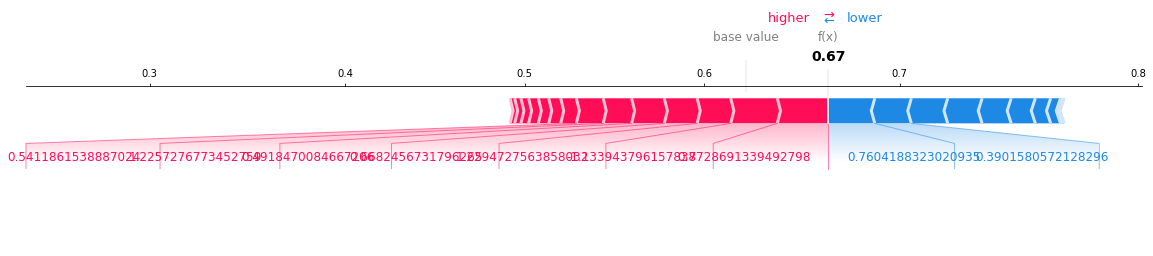

In [72]:
import matplotlib
import matplotlib.pyplot as plt
# print( shap_values_list )
# print the JS visualization code to the notebook
shap.initjs()
# print(shap_values[0, :])
# print(usable_features[0, :])
# shap.summary_plot(shap_values[:, :], usable_features[:, :])

shap.force_plot(.5, shap_values[0,:], usable_features[0, :], link = "logit", matplotlib = True)  

In [73]:
shap.force_plot(.5, shap_values[:,:], usable_features[:, :], link="logit")

In [74]:
# traits[20]
# shap_values = np.sum(shap_values_list)
# usable_features

In [75]:
# GWAS_IDS = ['ieu-b-109', 'ukb-b-12064', 'ukb-b-13806', 'ukb-d-20405_0', 'ieu-b-38', 'ukb-b-6134', 'ieu-b-110', 'ukb-b-17627', 'ukb-b-19953', 'ukb-b-8476', 'ukb-d-20405_1', 'ukb-d-20405_2', 'ukb-b-2209', 'ukb-b-4424', 'ukb-b-7663', 
#             'ukb-b-18275', 'ukb-b-770', 'met-d-Total_C', 'ieu-b-25', 'ieu-b-111', 'ukb-b-3957', 'ieu-b-39', 'ukb-b-6324',
#            'ukb-a-257','ukb-b-14699','ukb-b-323']
# # new added
# # ukb-a-257 Hearing difficulty/problems: Yes
# # ukb-b-14699 Illnesses of mother: Alzheimer's disease/dementia
# # ukb-b-323 Illnesses of father: Alzheimer's disease/dementia
GWAS_IDS=[
'ukb-b-2209',
'ieu-b-39',
'ukb-b-4424',
'ukb-b-7663',
'ukb-d-20405_2',
'ukb-b-6324',
'ieu-b-111',
'ukb-b-13806',
'ieu-b-25',
'ukb-d-20405_1',
'ukb-b-14699',
'ukb-b-770',
'ieu-b-109',
'ukb-d-20405_0',
'ieu-b-110',
'ukb-b-17627',
'ukb-a-257',
'ieu-b-38',
'ukb-b-18275',
'ukb-b-3957'   
]

# traits = ['HDL cholesterol', 'Non-cancer illness code, self-reported: depression', 
#           'Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 
#           'systolic blood pressure', 'Age completed full time education', 'LDL cholesterol', 
#           'Non-oily fish intake', 'Body mass index (BMI)', 'Loneliness, isolation', 
#           'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 
#           'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year',
#           'Oily fish intake', 'Sleep duration', 'Types of physical activity in last 4 weeks: Strenuous sports', 
#           'Hearing difficulty/problems with background noise', 'Other meat intake', 'Total cholesterol', 
#           'Cigarettes per Day', 'triglycerides', 'Sleeplessness / insomnia', 'diastolic blood pressure', 
#           'Processed meat intake','Hearing difficulty/problems: Yes','Illnesses of mother: Alzheimer\'s disease/dementia','Illnesses of father: Alzheimer\'s di



# for GWAS_ID in GWAS_IDS:
#     print(GWAS_ID)
# traits = ['HDL cholesterol', 'Non-cancer illness code, self-reported: depression', 
#           'Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 
#           'systolic blood pressure', 'Age completed full time education', 'LDL cholesterol', 
#           'Non-oily fish intake', 'Body mass index (BMI)', 'Loneliness, isolation', 
#           'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 
#           'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year',
#           'Oily fish intake', 'Sleep duration', 'Types of physical activity in last 4 weeks: Strenuous sports', 
#           'Hearing difficulty/problems with background noise', 'Other meat intake', 'Total cholesterol', 
#           'Cigarettes per Day', 'triglycerides', 'Sleeplessness / insomnia', 'diastolic blood pressure', 
#           'Processed meat intake','Hearing difficulty/problems: Yes','Illnesses of mother: Alzheimer\'s disease/dementia','Illnesses of father: Alzheimer\'s disease/dementia']

# # https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# # usable_features_std = (usable_features - usable_features.mean(0))/usable_features.std(0)
# shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot', max_display=len(traits))

26


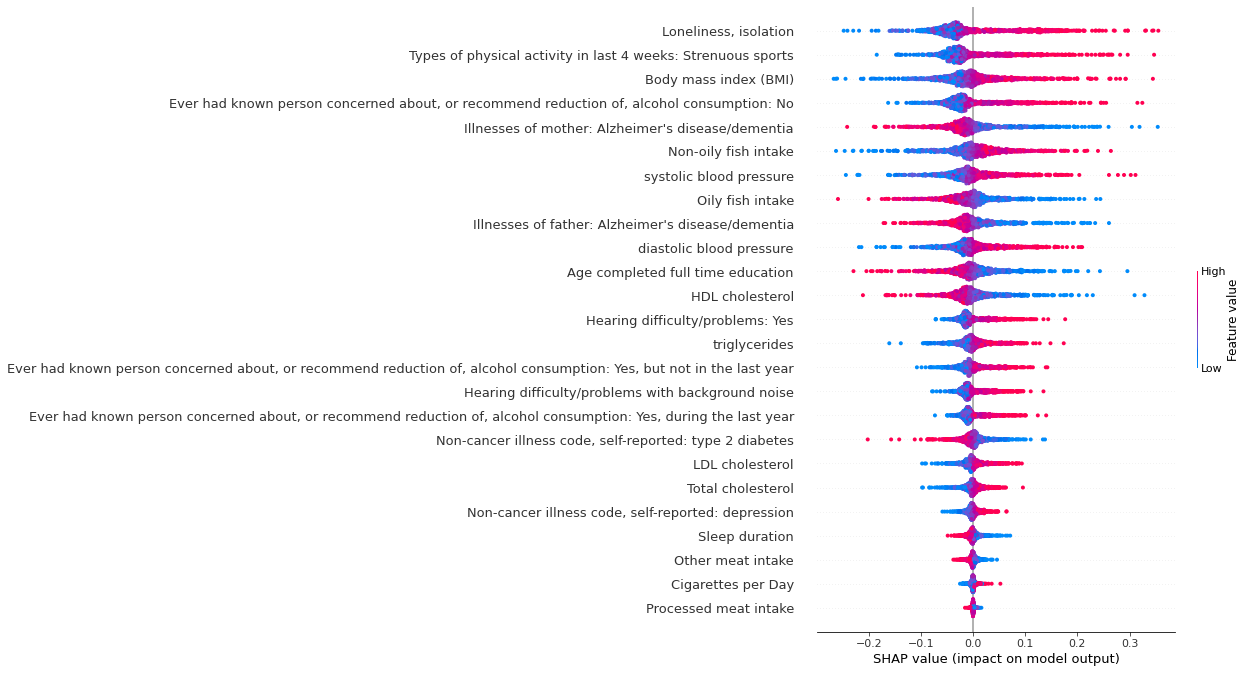

In [78]:
import json
# in place of json straight took it hardcoded

all_traits = json.load(open('traits_map.json', 'r'))
# print(all_traits)
GWAS_IDS = list(all_traits)
# print(GWAS_IDS)
traits = [all_traits[x] for x in all_traits]
print(len(traits))
# for trait in traits:
#     print(trait)
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# usable_features_std = (usable_features - usable_features.mean(0))/usable_features.std(0)
shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot', max_display=len(traits), show = False)
plt.savefig('shap/' + str(num_features) + '/summary_plot_hidden_'+ str(hidden) + '_dim_' + str(hidden_dimension) + '.pdf',  bbox_inches='tight')
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='dot', max_display=len(traits))

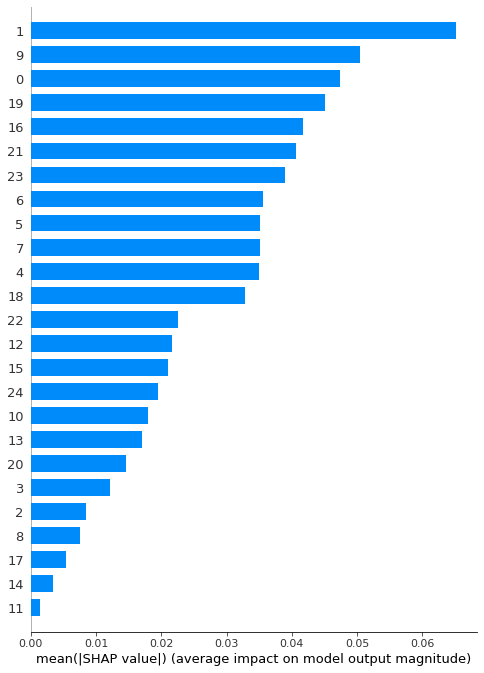

In [79]:
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')
# naeem modified
shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(num_features)), plot_type='bar', max_display=len(traits), show=False)
plt.savefig('shap/summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

In [80]:
sorted(list(zip(list(range(23)), abs(shap_values).mean(0))), key=lambda x:x[1], reverse=True)

[(1, 0.06510697660074626),
 (9, 0.05036167078912497),
 (0, 0.04744186851131602),
 (19, 0.04499924782516841),
 (16, 0.041631146143275795),
 (21, 0.04059851322177606),
 (6, 0.03556192528184169),
 (5, 0.03509093671979004),
 (7, 0.03505019824314685),
 (4, 0.03496573649676204),
 (18, 0.032850834781342486),
 (22, 0.02249594866265156),
 (12, 0.021643964872732173),
 (15, 0.020969169298746464),
 (10, 0.017997278486192623),
 (13, 0.017054682418431766),
 (20, 0.01460899001714733),
 (3, 0.012213027902940078),
 (2, 0.008455584097550223),
 (8, 0.00761619401331576),
 (17, 0.005396491383787103),
 (14, 0.0033587798097762384),
 (11, 0.0014317645188408178)]

In [81]:
help(shap.force_plot)


Help on function force in module shap.plots._force:

force(base_value, shap_values=None, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0, contribution_threshold=0.05)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, an

In [82]:

# print(Final_Samples)
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM

feature_indices_to_consider = list(range(0, 23)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]

usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])

Final_Samples = positive_samples[:500] + negative_samples[:500]
random.seed(2);random.shuffle(Final_Samples)
# Final_Samples = np.array(Final_Samples)
print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
print(sum(usable_labels), len(usable_labels))

X_train, X_test, y_train, y_test = train_test_split(
    usable_features, usable_labels, test_size=0.1)

X_train.shape, y_train.shape

X_test.shape, y_test.shape

print(y_test.sum(), y_test.shape)
clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
# clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam').fit(X_train, y_train)
clf.score(X_test, y_test)

500 500
500.0 1000
46.0 (100,)


0.6

In [83]:
random.shuffle(Final_Samples)
usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])


from sklearn.model_selection import KFold
X = usable_features[:, :23]
y = usable_labels
kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)
# print(y_test)
accuracies = []
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
#     print(y_test.sum(), y_test.shape)
    print(clf.score(X_test, y_test))
    accuracies += [clf.score(X_test, y_test)]
print(np.mean(accuracies), np.std(accuracies))


KFold(n_splits=10, random_state=None, shuffle=False)
0.74
0.58
0.57
0.66
0.53
0.53
0.59
0.67
0.57
0.66
0.6100000000000001 0.06542170893518452


In [84]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

accuracies = []
X = usable_features[:, :23]
y = usable_labels
kf = KFold(n_splits=10)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = RandomForestClassifier(random_state=0)
    reg.fit(X_train, y_train)
    print("Accuracy of model : ",reg.score(X_test, y_test)*100,"%")
#     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
#     print(y_test.sum(), y_test.shape)
    accuracies += [reg.score(X_test, y_test)]
print(np.mean(accuracies), np.std(accuracies))
save_in_file("Random Forest", np.mean(accuracies))

Accuracy of model :  73.0 %
Accuracy of model :  65.0 %
Accuracy of model :  57.99999999999999 %
Accuracy of model :  63.0 %
Accuracy of model :  59.0 %
Accuracy of model :  62.0 %
Accuracy of model :  57.99999999999999 %
Accuracy of model :  62.0 %
Accuracy of model :  61.0 %
Accuracy of model :  67.0 %
0.628 0.04377213725647859


In [85]:
from xgboost import XGBRegressor, XGBClassifier
model_name = "XGB"

accuracies = []
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = XGBClassifier()
    reg.fit(X_train, y_train)
    print("Accuracy of model : ",reg.score(X_test, y_test)*100,"%")
#     clf = MLPClassifier(hidden_layer_sizes=(32,8), activation='relu', solver='adam', max_iter=100, learning_rate='invscaling').fit(X_train, y_train)
#     print(y_test.sum(), y_test.shape)
    accuracies += [reg.score(X_test, y_test)]
print(np.mean(accuracies), np.std(accuracies))
save_in_file("XGBoost", np.mean(accuracies))


[21:07:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of model :  68.0 %
[21:07:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of model :  64.0 %
[21:07:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of model :  61.0 %
[21:07:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 

In [86]:
import csv

# open the file in the write mode
f = open('model_global_best_accuracy.csv', 'a')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(['num_features','num_nn_layers','global_best_accuracy'])
writer.writerow([str(num_features),str(hidden),str(global_best_acc_val)])

# close the file
f.close()